In [1]:
import gc
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
df_test = pd.read_csv('BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv')
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'], format='mixed')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161788 entries, 0 to 161787
Data columns (total 32 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   Timestamp                              161788 non-null  datetime64[ns]
 1   PT N2 'C' Speed                        161788 non-null  float64       
 2   Gear High Speed Drive End X Vibr       161788 non-null  float64       
 3   Gear High Speed Drive End Y Vibr       161788 non-null  float64       
 4   Gear High Speed Non-Drive End X Vibr   161788 non-null  float64       
 5   Gear High Speed Non-Drive End Y Vibr   161788 non-null  float64       
 6   Gear LS Shaft Axial Displ 1            161788 non-null  float64       
 7   Gear LS Shaft Axial Displ 2            161788 non-null  float64       
 8   Gear Low Speed Drive End X Vibr        161788 non-null  float64       
 9   Gear Low Speed DriveEnd Y Vibr         161788 no

In [3]:
# Helper function for selecting data easier
def data_selector(data, features, time_range_low=None, time_range_high=None):
    if time_range_low != None and time_range_high != None:
        data_selected_time = data.loc[(data['Timestamp'] >= time_range_low) & (data['Timestamp'] <= time_range_high)]
    elif time_range_low != None:
        data_selected_time = data.loc[(data['Timestamp'] >= time_range_low)]
    elif time_range_high != None:
        data_selected_time = data.loc[(data['Timestamp'] <= time_range_low)]
    data_selected = data_selected_time[features]
    return data_selected

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

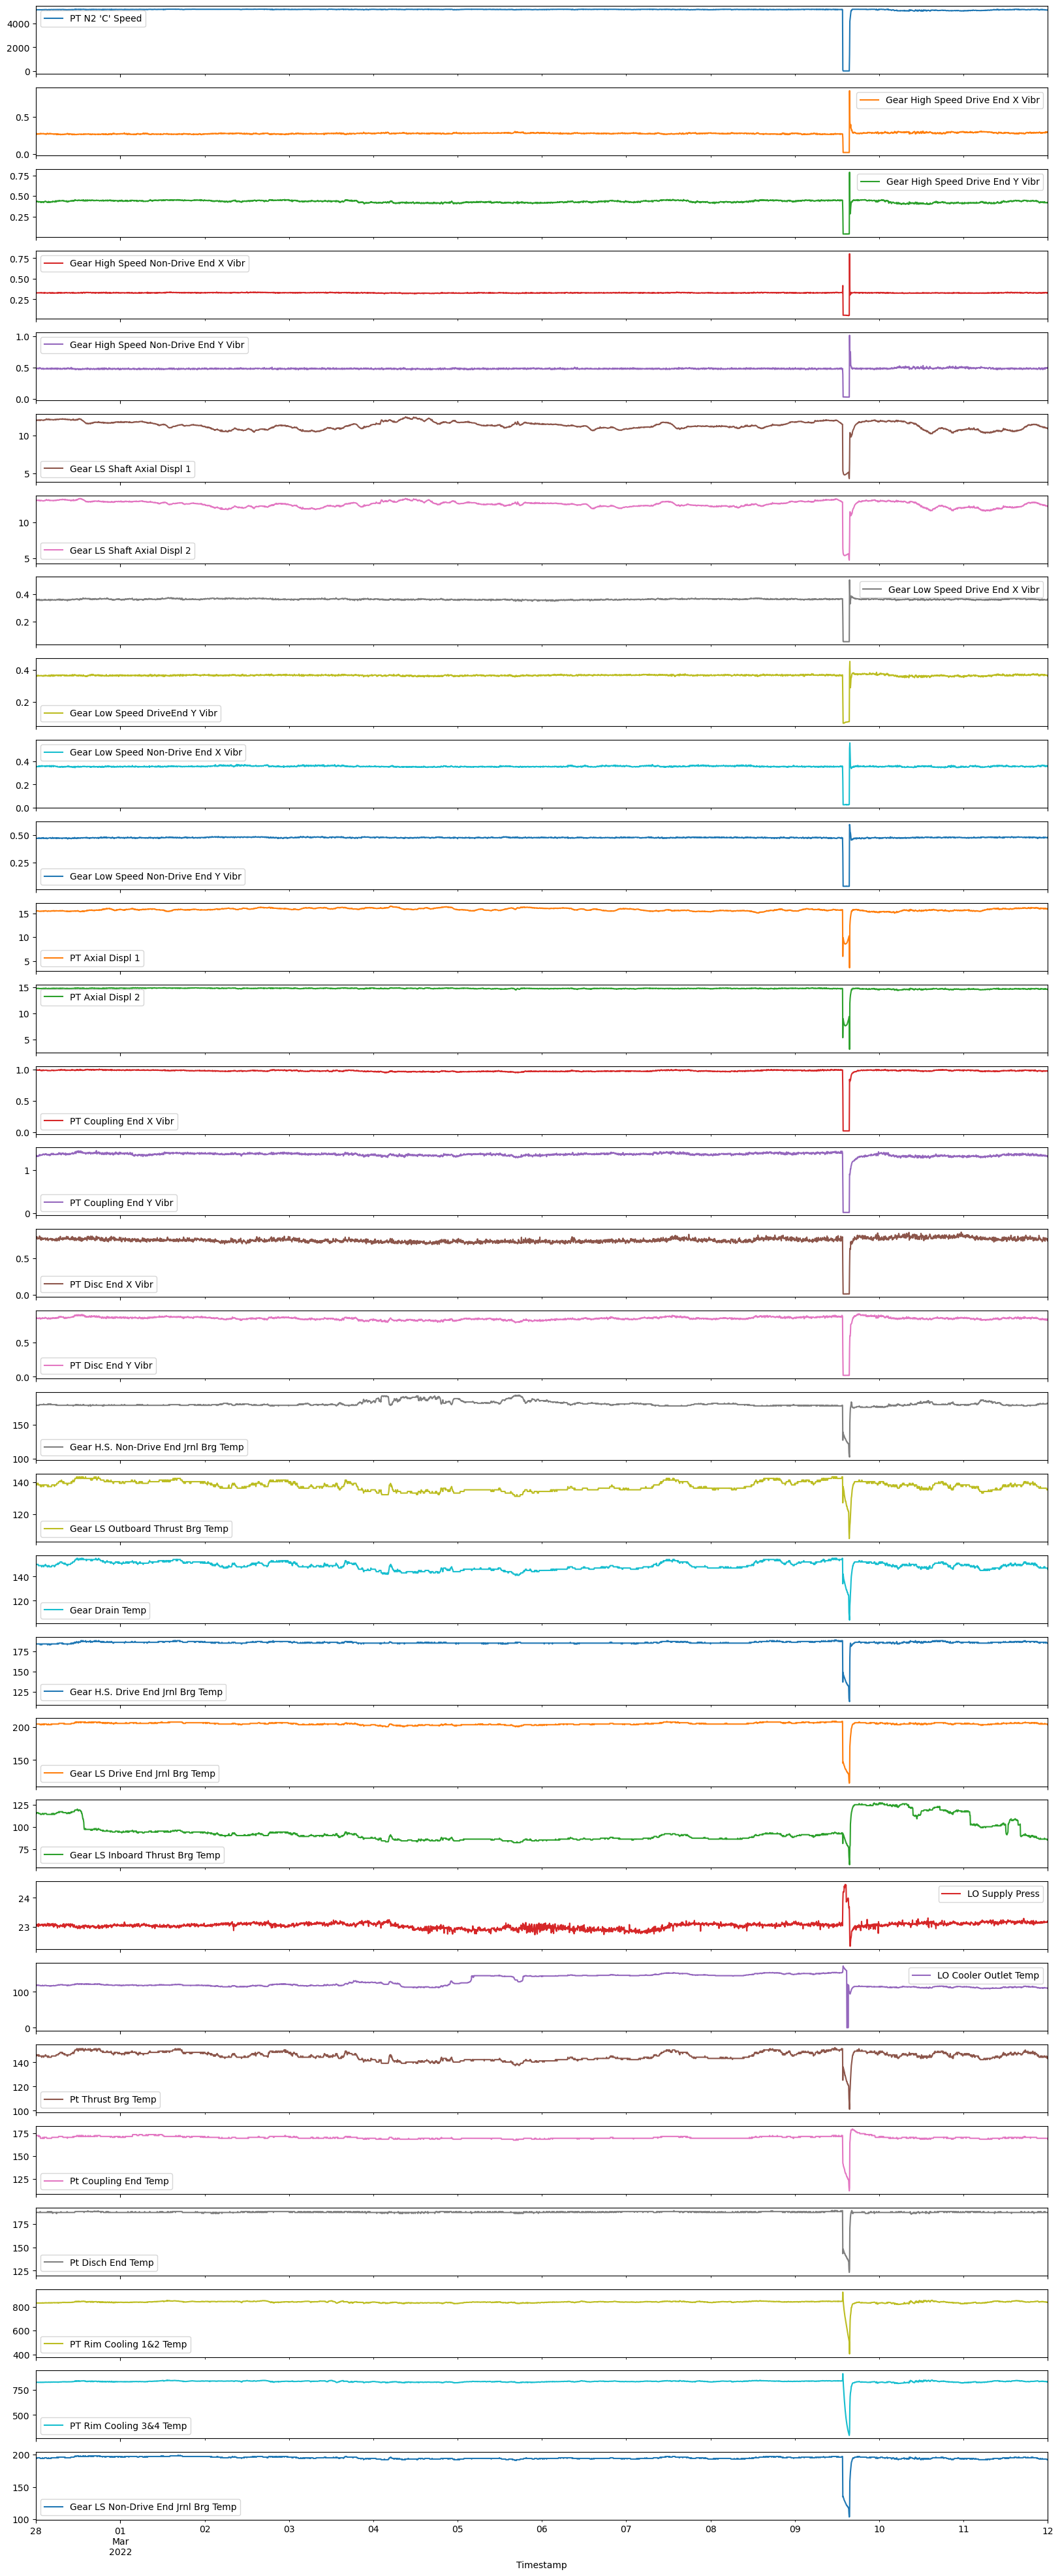

In [4]:
data_test = data_selector(df_test, df_test.columns, time_range_low='2022-02-28 00:00:00', time_range_high='2022-03-12 00:00:00')
data_test.plot(x='Timestamp',subplots=True, figsize=(20, 50))

In [5]:
features = data_test.drop('Timestamp', axis=1).columns.to_list()

In [6]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [7]:
x_test, y_test = lstm_data_transform(data_test.drop('Timestamp',axis=1).values, data_test.drop('Timestamp',axis=1).values, num_steps=10)

In [8]:
models = {}

for i, feature in enumerate(features):
    model = tf.keras.models.load_model(f'models_lstm/{feature}.h5')
    models[feature] = model

In [9]:
models['Gear Drain Temp'].summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 10, 50)            16200     
                                                                 
 lstm_43 (LSTM)              (None, 50)                20200     
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 36,451
Trainable params: 36,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
prediction = {}

for i, feature in enumerate(features):
    print('Testing model for feature', feature)
    model = models[feature]
    y_pred = model.predict(x_test[:, :, [j for j in range(len(features)) if j != i]])
    prediction[feature] = y_pred



Testing model for feature PT N2 'C' Speed
108/108 [==============================] - 5s 6ms/step
Testing model for feature Gear High Speed Drive End X Vibr
108/108 [==============================] - 1s 3ms/step
Testing model for feature Gear High Speed Drive End Y Vibr
108/108 [==============================] - 1s 3ms/step
Testing model for feature Gear High Speed Non-Drive End X Vibr
108/108 [==============================] - 1s 3ms/step
Testing model for feature Gear High Speed Non-Drive End Y Vibr
108/108 [==============================] - 1s 3ms/step
Testing model for feature Gear LS Shaft Axial Displ 1
108/108 [==============================] - 1s 4ms/step
Testing model for feature Gear LS Shaft Axial Displ 2
108/108 [==============================] - 1s 3ms/step
Testing model for feature Gear Low Speed Drive End X Vibr
108/108 [==============================] - 1s 3ms/step
Testing model for feature Gear Low Speed DriveEnd Y Vibr
108/108 [==============================] - 1s 3ms/s

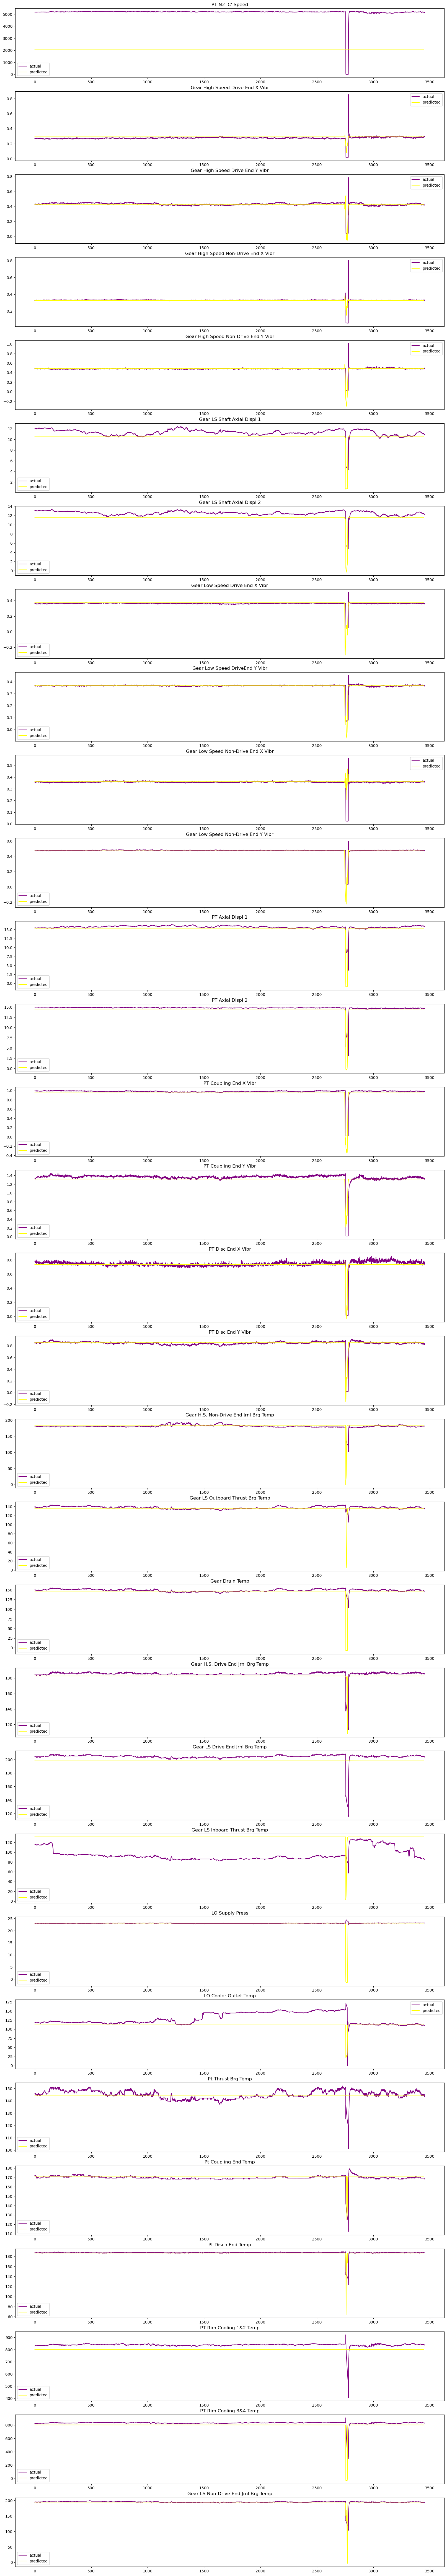

In [11]:
# Plotting the result# plot the predictions
fig, axs = plt.subplots(len(features), figsize=(20, 120))
for i, feature in enumerate(features):
    axs[i].plot(data_test[feature].values, label='actual', color='purple')
    axs[i].plot(prediction[feature], label='predicted', color='yellow')
    axs[i].set_title(feature)
    axs[i].legend()
